In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [2]:
 %matplotlib inline

## Generate Perlin Noise Map

In [3]:
#define noise map and final image

height = 128
width = 128
length = 128
num_sites = 10
generated_image = np.ones((height, width, length))


#define to be noise values
noise_values = np.ones((height, width, length))


sites = np.random.rand(num_sites, 3)
sites[:, 0] = np.rint(sites[:, 0] * (height-1))
sites[:, 1] = np.rint(sites[:, 1] * (width-1))
sites[:, 2] = np.rint(sites[:, 2] * (length-1))




In [4]:
import vec_noise as noise
import random

#help(vec_noise)

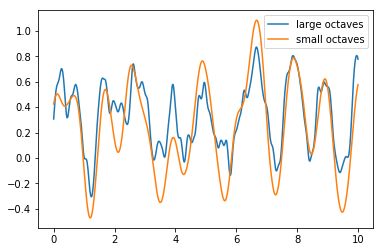

In [5]:
#for analyzing noise distributions

x_values = np.linspace(0, 10, num=800)
q = random.uniform(0.0, 10.0) #choose some random number between 0-10 to see how it'd vary on each axis
z = random.uniform(0.0, 10.0)
noise_func = lambda t, s: noise.snoise3(t, q, z, octaves=s) + 0.5 #octaves is number of random pts sampled and interpolated per interval

noise_computer = np.vectorize(noise_func)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_values, noise_computer(x_values, 3), label="large octaves") 

ax.plot(x_values, noise_computer(x_values, 1), label="small octaves")
ax.legend()



In [6]:
#generate noise map
import time
start = time.time()
grid = np.indices((height, width, length))
grid = np.transpose(grid)

grid = grid.reshape((height * width * length, 3))

grid = np.transpose(grid)


ga = np.multiply(grid[0],1.0/length)
gb = np.multiply(grid[1], 1.0/width)
gc = np.multiply(grid[2] , 1.0/height)

new_grid = np.vstack((ga, gb, gc))

final_grid = np.transpose(new_grid)

grid = np.multiply(final_grid , 10)

end = time.time()

print(end-start)

noise_func = lambda t, s: noise.snoise3(t[0], t[1], t[2], octaves=s) + 5 #octaves is number of random pts sampled and interpolated per interval
# it is possible to vectorize by flattening the array of indices, consider if needed again
#noise_computer = np.vectorize(noise_func)
#noise_computer = np.vectorize(noise_func)

noise_computer = np.vectorize(noise_func)
i = 0
noise_map = np.zeros((height * width * length))
for x in grid: 
    val = noise.snoise3(x[0], x[1], x[2], octaves=3) + 1
    noise_map[i] = val
    i= i + 1
    #noise_map = np.apply_along_axis(noise_computer, 1, grid, 4)

noise_map = noise_map.reshape((height, width, length))
end2 = time.time()
print(end2-end)

print((noise_map.flatten() < 0).sum())
#print("min noise value: %f"% np.amin(noise_map))
#print("max noise value: %f"% np.amax(noise_map))


0.22694778442382812
4.399327278137207
0


## Generate Graph and Outline Image

In [7]:
#Load content model

import modules.binvox_rw as bv
import pyqtgraph.opengl as gl
model="stext_2.binvox"
main_model =  np.zeros((height, width, length, 4), dtype=np.uint8) 
main_model_bin = np.zeros((height, width, length), dtype=bool)
with open(model, 'rb') as f:
    main_model_bin = bv.read_as_3d_array(f).data


main_model[main_model_bin] = 255 


from pyqtgraph.Qt import QtCore, QtGui
import sys
def display_volume(model_data):
    
    %gui qt
    app = QtGui.QApplication([])
    vol_item = gl.GLVolumeItem(model_data, sliceDensity=1, smooth=True)

    
    
    w = gl.GLViewWidget()
    w.opts['distance'] = 200
    w.show()
    w.setWindowTitle('pyqtgraph example: GLVolumeItem')
    
    g = gl.GLGridItem()
    g.scale(10, 10, 1)
    w.addItem(g)
    
    vol_item.translate(-1 * height,-1 * width,-1 * length)
    w.addItem(vol_item)
    


    ax = gl.GLAxisItem()
    w.addItem(ax)


    app.exec_()
    
        
#display_volume(main_model)


In [8]:
import queue as q
import heapq
import functools
from modules.priority_dict import *
#define node class, 4 lattice graph of node objects

@functools.total_ordering

class Node(object): 
    def __init__(self, curr_site=(num_sites +1), priority=0.0, boundary=False, frontier=True, row=0, col=0, plane=0):
        self.curr_site = curr_site
        self.priority = priority
        self.frontier = frontier
        self.row = row
        self.col = col
        self.plane = plane
    def __hash__(self):
        return int(str(self.row) + str(self.col))
    def __eq__(self, other):
        return self.row == other.row and self.col == other.col
    def __lt__(self, other):
        return self.priority < other.priority
    
#initialize start points for dijkstras
lattice = np.empty( (height,width, length), dtype=Node)

counter = 0
p_q = priority_dict()


#initialize sites
for site in sites:
    site = site.astype(int)
    temp_node = Node(counter, priority=0.0, row=site[0], col=site[1], plane=site[2])
    
    lattice[site[0], site[1], site[2]] = temp_node
    p_q[temp_node] = 0.0
    counter= counter + 1
            
    

In [9]:
alpha = 6
beta =  1/6.0 * alpha
gamma = (alpha + beta) * 8


boundary_locations = np.ones((height, width, length), dtype=bool)

def calculate_cost(row, col, plane, row_two, col_two, plane_two):
    return beta + lattice[row, col, plane].priority + (alpha * max(noise_map[row, col, plane_two], noise_map[row_two, col_two, plane_two])) + gamma * int(main_model_bin[row, col, plane])


#return True fall based on whether we have reached dijkstra cost limit
def node_update(curr_node, row_two, col_two, plane_two):
    
    #curr node is node being explored
    sec_node = lattice[row_two, col_two, plane_two] #node two be updated
    


    if curr_node.priority > 2000:
        boundary_locations[curr_node.row, curr_node.col, curr_node.plane] = True
        return True
        
        
    if sec_node is None: #if node in sec_node in lattice not initialized yet
        cost = calculate_cost(curr_node.row, curr_node.col, curr_node.plane, row_two, col_two, plane_two)
        lattice[row_two, col_two, plane_two] = Node(curr_node.curr_site, priority = cost, row=row_two, col=col_two, plane=plane_two)  
        p_q[lattice[row_two, col_two, plane_two]] = cost
        boundary_locations[curr_node.row, curr_node.col, curr_node.plane] = False
    elif sec_node.frontier == True: #if frontier

        if sec_node.curr_site != curr_node.curr_site: #check if boundary node
            boundary_locations[curr_node.row, curr_node.col, curr_node.plane] = True
        else:
            boundary_locations[curr_node.row, curr_node.col, curr_node.plane] = False
            #otherwise update priority if it less than current
            cost = calculate_cost(curr_node.row, curr_node.col, curr_node.plane, sec_node.row, sec_node.col, sec_node.plane) #attempt cost update
            if cost < sec_node.priority: 
                p_q[lattice[sec_node.row, sec_node.col, sec_node.plane]] = cost
                lattice[sec_node.row, sec_node.col, sec_node.plane].priority = cost
        
    return False
            
final_val = False
while p_q:
    
    curr_node = p_q.pop_smallest()
    lattice[curr_node.row, curr_node.col, curr_node.plane].frontier = False
    
    
    if final_val == True:
        boundary_locations[curr_node.row, curr_node.col, curr_node.plane] = True
        continue
    
    
    counter = counter + 1
    if curr_node.row - 1 >= 0:
        a = node_update(curr_node, curr_node.row - 1, curr_node.col, curr_node.plane)
    if curr_node.row + 1 < height:
        b = node_update(curr_node, curr_node.row + 1, curr_node.col, curr_node.plane)
    if curr_node.col - 1 >= 0:
        c = node_update(curr_node,  curr_node.row, curr_node.col -1, curr_node.plane)
    if curr_node.col + 1 < width:
        d = node_update(curr_node, curr_node.row, curr_node.col + 1, curr_node.plane)
    if curr_node.plane + 1 < length:
        e2 = node_update(curr_node, curr_node.row, curr_node.col, curr_node.plane + 1)
    if curr_node.plane >= 0:
        f = node_update(curr_node, curr_node.row, curr_node.col, curr_node.plane - 1)
    
    final_val = a or b or c or d or e2 or f
    
    
    

In [10]:
color_list = [[1.0, 0.0, 0.0], [0.2, 0.3, 0.4], [0.8, 0.5, 0.8], [0.1, 0.4, 0.2], [0.4, 0.1, 0.5], [0.2, 0.9, 0.1], [0.3, 0.6, 0.1], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 1.0, 0], [1.0, 0.0, 1.0], [0.0, 1.0, 1.0]]
boundary_color = [0.0, 0.0, 0.0]

In [11]:
img_for_interm_analysis = np.zeros((height, width, length, 4), dtype=np.uint8);
img_for_interm_analysis[boundary_locations] =  np.asarray([255, 255, 255, 255], dtype=np.uint8)

In [12]:
display_volume(img_for_interm_analysis)

## Crack Width Tapering

In [13]:
# def bresenham(x1, y1, x2, y2, x_start, flipped):
#     y = y1 
#     twice_dx = 2 * (x2 - x1)
#     twice_dy = 2 * (y2 - y1);
#     twice_dy_minus_twice_dx = twice_dy - twice_dx;
#     d = twice_dx // 2 - twice_dy;
#     if x_start > x2:
#         x_start = x_start + x2
#         x2 = x_start - x2
#         x_start = x_start - x2
    
#     for x in range(x_start, x2):
#         if flipped == True:
#             if(x<0 or x>=height):
#                 continue;
#             lattice[x, y].boundary = True
#         else: 
#             if(y<0 or y>=height):
#                 continue;
#             lattice[y, x].boundary = True 
#         if d > 0: 
#             d -= twice_dy
#         else:
#             y= (y + 1); 
#             d -= twice_dy_minus_twice_dx 


# def flood_fill_depth(depth, r, c): 
#     q_f = q.Queue()
#     iteration = 0
#     q_f.put(lattice[r, c])
#     while iteration < depth and not q_f.empty():
#         curr_node = q_f.get()
#         r = curr_node.row
#         c = curr_node.col
        
#         if c+1 < width:
#             if lattice[r, c+1].curr_site == curr_node.curr_site:
#                 q_f.put(lattice[r, c+1])
#                 lattice[r, c+1].boundary = True
#         if c-1 >= 0:
#             if lattice[r, c-1].curr_site == curr_node.curr_site:
#                 q_f.put(lattice[r, c-1])
#                 lattice[r, c-1].boundary = True
#         if r+1 < height:
#             if lattice[r+1, c].curr_site == curr_node.curr_site:
#                 q_f.put(lattice[r+1, c])
#                 lattice[r+1, c].boundary = True
#         if r-1 >= 0:
#             if lattice[r-1, c].curr_site == curr_node.curr_site:
#                 q_f.put(lattice[r-1, c])
#                 lattice[r-1, c].boundary = True
#         iteration = iteration + 1

# for loc in boundary_locations:
#     vornoi_site = lattice[loc[0], loc[1]].curr_site
#     vornoi_site_data = sites[vornoi_site].astype(int)
#     manhattan = vornoi_site_data - np.asarray([loc[0],loc[1]], dtype=np.int32)
#     delta_y = manhattan[0]
#     delta_x = manhattan[1]
    
    
#     #attempt with basic flood fill
#     euclidean_distance = (delta_y**2 + delta_x**2)**(1/2)
#     depth = int(0.02 * euclidean_distance)
#     flood_fill_depth(depth, loc[0], loc[1])
    
#     #attempt with bresenham by extending line along euclidean displacement vector -- currently doesn't work
    
#     #if abs(delta_y) > abs(delta_x):
#         #slope is greater than 1
#         #bresenham(vornoi_site_data[0],vornoi_site_data[1], loc[0], loc[1], loc[0] + int(0.1 * delta_x)//delta_y, True)
#     #else: 
#         #print("loc 1: %d vornoi site: %d start %d"%(loc[1], vornoi_site_data[1], (loc[1] + delta_x//10)))
#         #bresenham(vornoi_site_data[1], vornoi_site_data[0], loc[1], loc[0], (loc[1] + int(0.1 * delta_y)//delta_x), False)

    
    
    

## Display Outline Image

In [14]:
# color_list = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 1.0, 0], [1.0, 0.0, 1.0], [0.0, 1.0, 1.0]]
# boundary_color = [0.0, 0.0, 0.0]

In [15]:
# img_for_interm_analysis = np.ones((height, width, 3));
# for r in range(0, height): 
#     for c in range(0, width):
#         img_for_interm_analysis[r, c] = np.asarray([1.0, 1.0, 1.0])
#         if lattice[r, c].boundary == True:
#             img_for_interm_analysis[r, c] = np.asarray(boundary_color)

In [16]:
# plt.imshow(img_for_interm_analysis)